In [ ]:
# Install rstan, brms, and dependencies if not already installed
packages <- c("Rcpp", "RcppEigen", "inline", "BH", "StanHeaders", "rstan", "brms")
missing <- packages[!(packages %in% installed.packages()[,"Package"])]
if(length(missing) > 0) {
  install.packages(missing, dependencies = TRUE, repos = "https://cloud.r-project.org")
}

In [1]:
# Load necessary libraries
library(brms)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(here)
setwd(here("final_paper_analysis"))

Loading required package: Rcpp

Loading 'brms' package (version 2.22.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


Warning message:
“package ‘ggplot2’ was built under R version 4.5.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
here() starts at /Users/aschharwood/evaluating_organic_waste_bans



# Data

In [2]:
df <- read.csv("data.csv")
df$sector_name <- as.factor(df$sector_name)
glimpse(df)



Rows: 64
Columns: 8
$ state                          <chr> "california", "california", "california…
$ year                           <int> 1999, 2003, 2008, 2008, 2014, 2018, 201…
$ sector_name                    <fct> sector_combined, sector_combined, secto…
$ log_food_tons                  <dbl> 15.53551, 15.58270, 14.92541, 14.92500,…
$ adjusted_quant_score_linear    <dbl> 0.000000, 0.000000, 0.000000, 0.000000,…
$ inflation_adjusted_tipping_fee <dbl> 47.03000, 47.03100, 53.05004, 53.05004,…
$ pce_scaled                     <dbl> 15.0934096, 17.0308663, 18.8109959, 18.…
$ centered_search                <dbl> 4.2018229, 4.2018229, 4.2018229, 4.2018…


# Models

### Log-Log with Strong Prior

In [3]:
fit_log_strong_prior <- readRDS('models/strong_prior_model.rds')

In [ ]:
# Code used to fit model
# **Note: I suggest using the rds file, instead of refitting the model**

# prior_final <- c(
#     prior(normal(-0.025, 0.006), class = "b", coef = "adjusted_quant_score_linear")
# )

# fit_log_strong_prior <- brm(
#     formula = log_food_tons ~ adjusted_quant_score_linear +
#         log(pce_scaled) + centered_search +
#         inflation_adjusted_tipping_fee + sector_name +
#         (1 | state),
#     data = df,
#     prior = prior_final,
#     family = gaussian(),
#     iter = 4000, chains = 4, cores = 4,
#     control = list(adapt_delta = .95),
#     save_pars = save_pars(all = TRUE)
# )

#### Results

In [4]:
summary(fit_log_strong_prior)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log(food_tons_clean) ~ adjusted_quant_score_linear + log(pce_scaled) + centered_search + inflation_adjusted_tipping_fee + sector_name + (1 | state) 
   Data: df (Number of observations: 64) 
  Draws: 4 chains, each with iter = 4000; warmup = 2000; thin = 1;
         total post-warmup draws = 8000

Multilevel Hyperparameters:
~state (Number of levels: 22) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.20      0.06     0.09     0.33 1.00     2341     2556

Regression Coefficients:
                               Estimate Est.Error l-95% CI u-95% CI Rhat
Intercept                         12.33      0.35    11.68    13.02 1.00
adjusted_quant_score_linear       -0.02      0.01    -0.03    -0.01 1.00
logpce_scaled                      1.05      0.07     0.91     1.17 1.00
centered_search                   -0.01      0.00    -0.02     0.00 1.00
inflation_adjusted_tipping_fee   

#### PP_Check

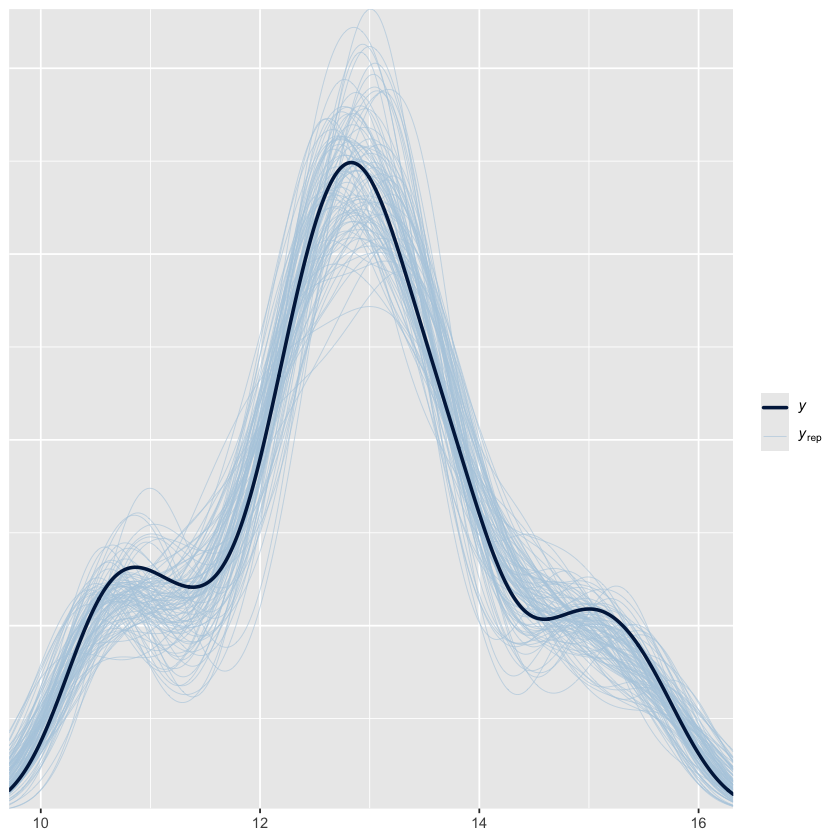

In [5]:
pp_check(fit_log_strong_prior, ndraws = 100)

In [6]:
loo_strong_prior <- loo::loo(fit_log_strong_prior, moment_match = TRUE)

In [7]:
loo_strong_prior


Computed from 8000 by 64 log-likelihood matrix.

         Estimate   SE
elpd_loo     -8.5  6.7
p_loo        16.0  2.9
looic        17.1 13.4
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.4, 1.5]).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.

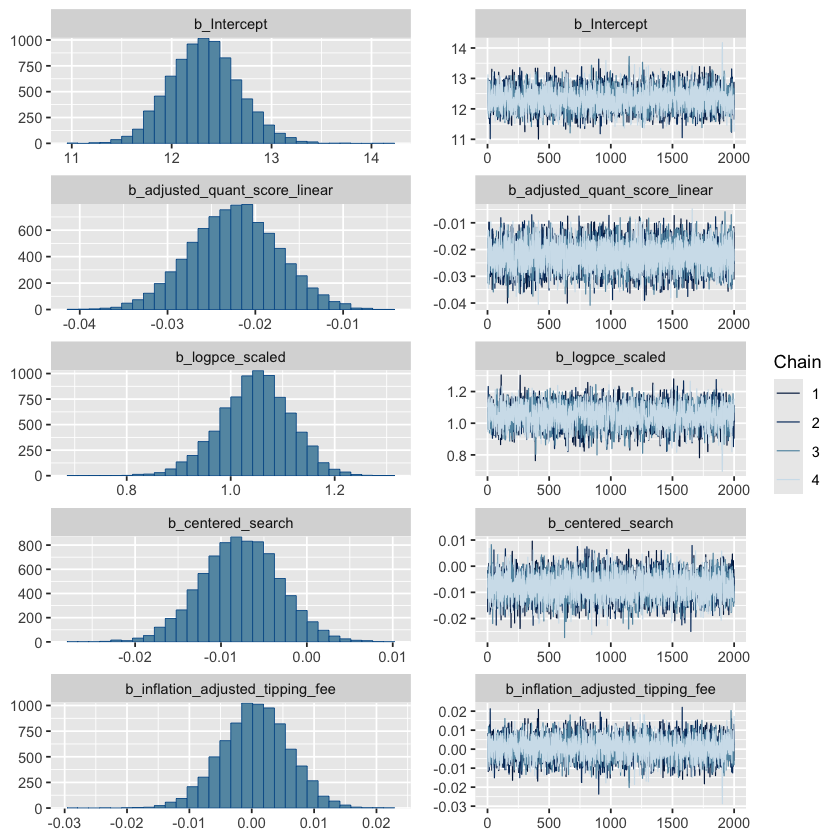

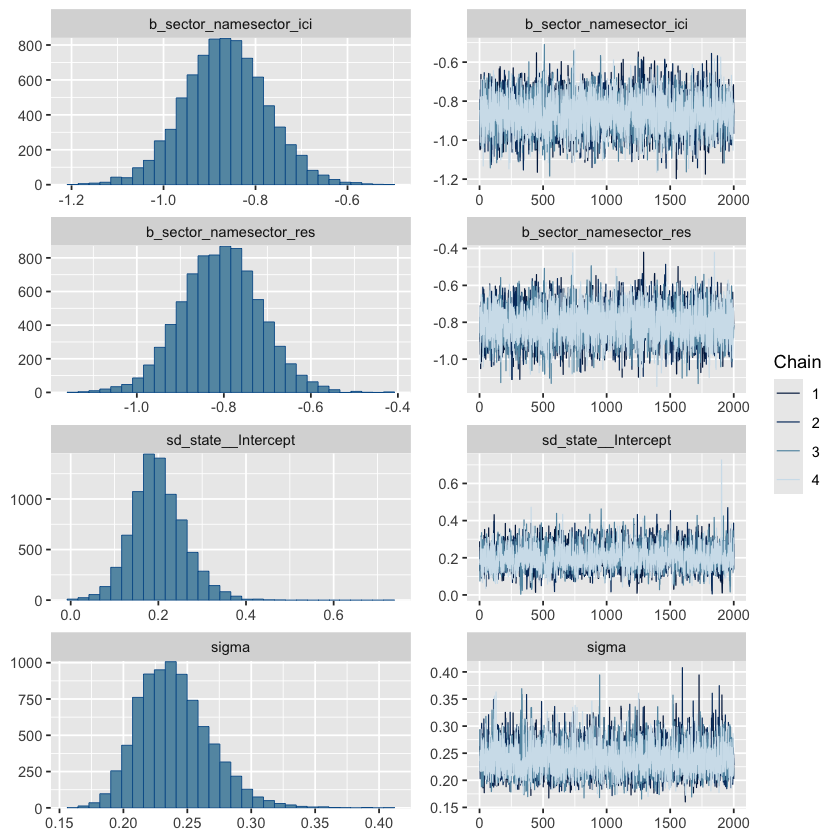

In [10]:
plot(fit_log_strong_prior)

In [8]:
prior_summary(fit_log_strong_prior)

prior,class,coef,group,resp,dpar,nlpar,lb,ub,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,,default
"normal(-0.025, 0.006)",b,adjusted_quant_score_linear,,,,,,,user
,b,centered_search,,,,,,,default
,b,inflation_adjusted_tipping_fee,,,,,,,default
,b,logpce_scaled,,,,,,,default
,b,sector_namesector_ici,,,,,,,default
,b,sector_namesector_res,,,,,,,default
"student_t(3, 12.9, 2.5)",Intercept,,,,,,,,default
"student_t(3, 0, 2.5)",sd,,,,,,0,,default


## Log-Log Uninformative Prior

In [ ]:
# Original code used to fit model
# **Note: I suggest using the rds file, instead of refitting the model**

# fit_log_uninformative_prior <- brm(
#     formula = log(food_tons_clean) ~ adjusted_quant_score_linear +
#         log(pce_scaled) + centered_search +
#         inflation_adjusted_tipping_fee + sector_name +
#         (1 | state),
#     data = df,
#     family = gaussian(),
#     iter = 4000, chains = 4, cores = 4,
#     control = list(adapt_delta = .95),
#     save_pars = save_pars(all = TRUE)
# )

In [ ]:
fit_log_uninformative_prior <- readRDS("models/uninformative_prior_model.rds")


### Results

In [ ]:
summary(fit_log_uninformative_prior)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log(food_tons_clean) ~ adjusted_quant_score_linear + log(pce_scaled) + centered_search + inflation_adjusted_tipping_fee + sector_name + (1 | state) 
   Data: df (Number of observations: 64) 
  Draws: 4 chains, each with iter = 4000; warmup = 2000; thin = 1;
         total post-warmup draws = 8000

Multilevel Hyperparameters:
~state (Number of levels: 22) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.19      0.06     0.08     0.33 1.00     1988     2158

Regression Coefficients:
                               Estimate Est.Error l-95% CI u-95% CI Rhat
Intercept                         12.37      0.33    11.72    13.05 1.00
adjusted_quant_score_linear       -0.02      0.01    -0.03     0.00 1.00
logpce_scaled                      1.05      0.07     0.91     1.17 1.00
centered_search                   -0.01      0.00    -0.02     0.00 1.00
inflation_adjusted_tipping_fee   

### Diagnostics

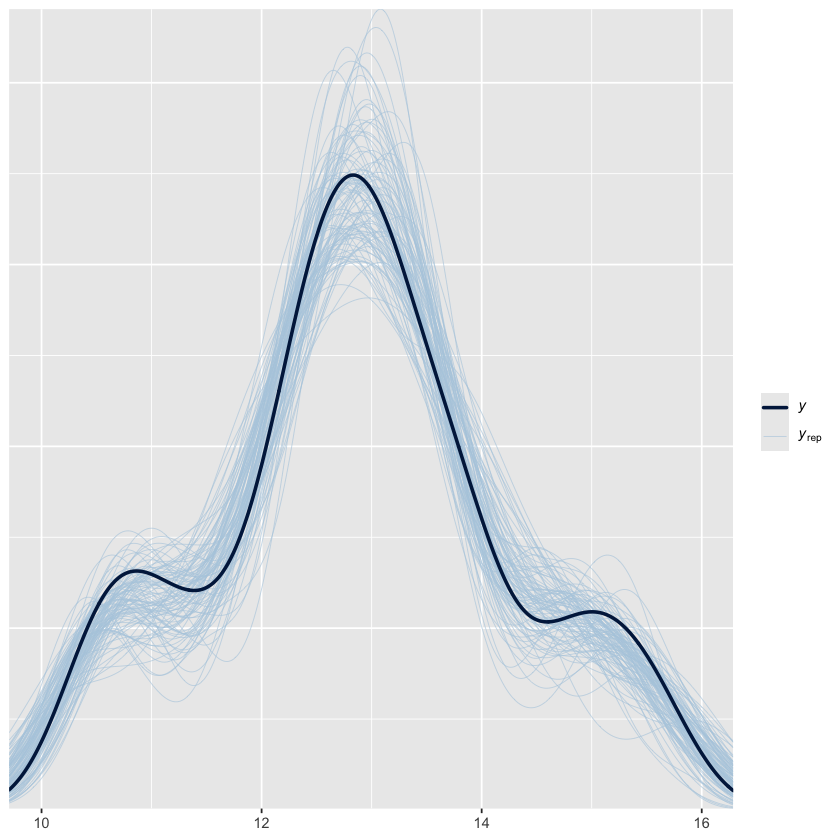

In [ ]:
pp_check(fit_log_uninformative_prior, ndraws = 100)

In [ ]:
loo_log_uninformative <- loo::loo(fit_log_uninformative_prior, moment_match = TRUE)

In [46]:
loo_log_uninformative


Computed from 8000 by 64 log-likelihood matrix.

         Estimate   SE
elpd_loo     -9.4  6.6
p_loo        16.5  2.9
looic        18.8 13.1
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.4, 1.5]).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.